<a href="https://colab.research.google.com/github/alaa-orabi/AI-Uni-project/blob/main/EfficientNetB3_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data loading, cleaning, and augmentation steps for EfficientNetB3 model**

#📌1. Import Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import random
import shutil
from sklearn.model_selection import train_test_split


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



#📌2. Downloading the PlantVillage Dataset

In [ ]:
import kagglehub


path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


In [ ]:
import os

# Correct PlantVillage path from KaggleHub
data_root = os.path.join(path, "PlantVillage")

# List classes
classes = sorted(os.listdir(data_root))

print("Number of Classes:", len(classes))
print(classes[:20])

Number of Classes: 15
['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
# ============================================
# Format Class Names - View 15 Examples
# ============================================

def format_class_name(class_name):

    # Replace underscores with spaces
    formatted = class_name.replace('___', ' - ')  # Replace triple underscore with dash
    formatted = formatted.replace('__', ' ')      # Replace double underscore with space
    formatted = formatted.replace('_', ' ')       # Replace single underscore with space

    # Capitalize each word
    formatted = formatted.title()

    return formatted

# Display before and after for first 15 classes
print(f"{'='*100}")
print(f"CLASS NAME FORMATTING - FIRST 15 CLASSES")
print(f"{'='*100}")
print(f"{'No.':<5} {'Original':<50} {'Formatted':<45}")
print(f"{'-'*100}")

for idx, cls in enumerate(classes[:15], 1):
    formatted = format_class_name(cls)
    print(f"{idx:<5} {cls:<50} {formatted:<45}")

print(f"{'='*100}")

CLASS NAME FORMATTING - FIRST 15 CLASSES
No.   Original                                           Formatted                                    
----------------------------------------------------------------------------------------------------
1     Pepper__bell___Bacterial_spot                      Pepper Bell - Bacterial Spot                 
2     Pepper__bell___healthy                             Pepper Bell - Healthy                        
3     Potato___Early_blight                              Potato - Early Blight                        
4     Potato___Late_blight                               Potato - Late Blight                         
5     Potato___healthy                                   Potato - Healthy                             
6     Tomato_Bacterial_spot                              Tomato Bacterial Spot                        
7     Tomato_Early_blight                                Tomato Early Blight                          
8     Tomato_Late_blight          

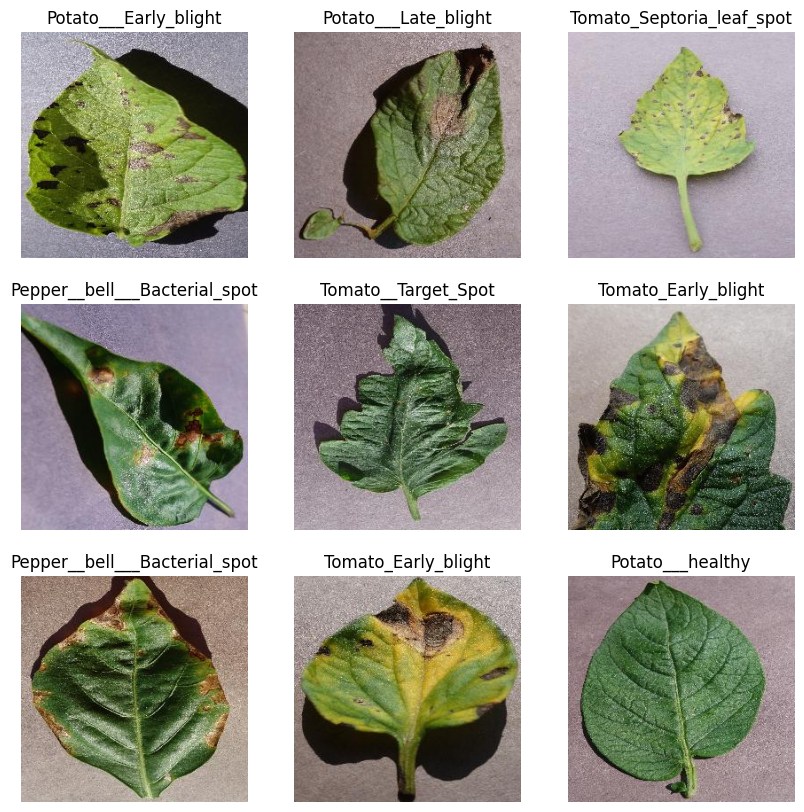

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image

plt.figure(figsize=(10,10))

for i in range(9):
    cls = random.choice(classes)
    img_path = os.path.join(data_root, cls, random.choice(os.listdir(os.path.join(data_root, cls))))
    img = Image.open(img_path)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.show()


#📌2. Count number of corrupted Images

In [ ]:
import os
from PIL import Image

data_root = os.path.join(path, "PlantVillage")   # your KaggleHub dataset path

corrupted_images = []

for cls in os.listdir(data_root):
    cls_path = os.path.join(data_root, cls)
    if not os.path.isdir(cls_path):
        continue

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)

        try:
            img = Image.open(img_path)
            img.verify()   # verifies file integrity
        except Exception:
            corrupted_images.append(img_path)

print("Total corrupted images found:", len(corrupted_images))

if corrupted_images:
    print("\nList of corrupted image files:")
    for img in corrupted_images:
        print(img)
else:
    print("No corrupted images found. Dataset is clean!")


Total corrupted images found: 1

List of corrupted image files:
/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/svn-r6Yb5c


#Count images per class

In [ ]:
# ============================================
# Print Image Count for Each Class (SORTED Descending)
# ============================================

class_distribution = {}
for cls in classes:
    cls_path = os.path.join(data_root, cls)
    if os.path.isdir(cls_path):
        num_images = len([f for f in os.listdir(cls_path)
                         if os.path.isfile(os.path.join(cls_path, f))])
        class_distribution[cls] = num_images

# Sort by count (descending order - highest to lowest)
sorted_classes = sorted(class_distribution.items(), key=lambda x: x[1], reverse=True)

# Print header
print(f"{'='*80}")
print(f"IMAGE COUNT PER CLASS (SORTED BY COUNT Descending)")
print(f"{'='*80}")
print(f"{'No.':<5} {'Class Name':<50} {'Count':>10}")
print(f"{'-'*80}")

# Print each class with its count
for idx, (cls_name, count) in enumerate(sorted_classes, 1):
    print(f"{idx:<5} {cls_name:<50} {count:>10,}")

# Print summary statistics
print(f"{'-'*80}")
print(f"{'TOTAL CLASSES':<55} {len(class_distribution):>10}")
print(f"{'TOTAL IMAGES':<55} {sum(class_distribution.values()):>10,}")
print(f"{'AVERAGE IMAGES PER CLASS':<55} {sum(class_distribution.values())//len(class_distribution):>10,}")
print(f"{'MIN IMAGES IN A CLASS':<55} {min(class_distribution.values()):>10,}")
print(f"{'MAX IMAGES IN A CLASS':<55} {max(class_distribution.values()):>10,}")
print(f"{'='*80}")

IMAGE COUNT PER CLASS (SORTED BY COUNT Descending)
No.   Class Name                                              Count
--------------------------------------------------------------------------------
1     Tomato__Tomato_YellowLeaf__Curl_Virus                   3,209
2     Tomato_Bacterial_spot                                   2,127
3     Tomato_Late_blight                                      1,909
4     Tomato_Septoria_leaf_spot                               1,771
5     Tomato_Spider_mites_Two_spotted_spider_mite             1,676
6     Tomato_healthy                                          1,591
7     Pepper__bell___healthy                                  1,478
8     Tomato__Target_Spot                                     1,404
9     Potato___Early_blight                                   1,000
10    Potato___Late_blight                                    1,000
11    Tomato_Early_blight                                     1,000
12    Pepper__bell___Bacterial_spot                 

In [ ]:
# ============================================
# Count Duplicates Per Class
# ============================================

import hashlib
from collections import defaultdict

def get_image_hash(img_path):
    """Calculate MD5 hash of an image"""
    with open(img_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

print("Checking for duplicates in each class...\n")

# Dictionary to store duplicates per class
class_duplicates = {}

for cls in classes:
    cls_path = os.path.join(data_root, cls)
    if not os.path.isdir(cls_path):
        continue

    # Hash all images in this class
    image_hashes = defaultdict(list)

    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        if os.path.isfile(img_path):
            img_hash = get_image_hash(img_path)
            image_hashes[img_hash].append(img_path)

    # Count duplicates (hashes that appear more than once)
    duplicate_count = sum(1 for paths in image_hashes.values() if len(paths) > 1)
    class_duplicates[cls] = duplicate_count

# Print results
print(f"{'='*80}")
print(f"DUPLICATE COUNT PER CLASS")
print(f"{'='*80}")
print(f"{'No.':<5} {'Class Name':<50} {'Duplicates':>10}")
print(f"{'-'*80}")

for idx, cls in enumerate(classes, 1):
    dup_count = class_duplicates.get(cls, 0)
    status = "✓" if dup_count == 0 else f"⚠️ {dup_count}"
    print(f"{idx:<5} {cls:<50} {dup_count:>10}")

# Summary
print(f"{'-'*80}")
total_duplicates = sum(class_duplicates.values())
classes_with_duplicates = sum(1 for count in class_duplicates.values() if count > 0)
classes_without_duplicates = len(classes) - classes_with_duplicates

print(f"{'TOTAL DUPLICATE SETS':<55} {total_duplicates:>10}")
print(f"{'CLASSES WITH DUPLICATES':<55} {classes_with_duplicates:>10}")
print(f"{'CLASSES WITHOUT DUPLICATES':<55} {classes_without_duplicates:>10}")
print(f"{'='*80}")


Checking for duplicates in each class...

DUPLICATE COUNT PER CLASS
No.   Class Name                                         Duplicates
--------------------------------------------------------------------------------
1     Pepper__bell___Bacterial_spot                               0
2     Pepper__bell___healthy                                      0
3     Potato___Early_blight                                       0
4     Potato___Late_blight                                        0
5     Potato___healthy                                            0
6     Tomato_Bacterial_spot                                       0
7     Tomato_Early_blight                                         0
8     Tomato_Late_blight                                          8
9     Tomato_Leaf_Mold                                            0
10    Tomato_Septoria_leaf_spot                                   0
11    Tomato_Spider_mites_Two_spotted_spider_mite                 0
12    Tomato__Target_Spot          

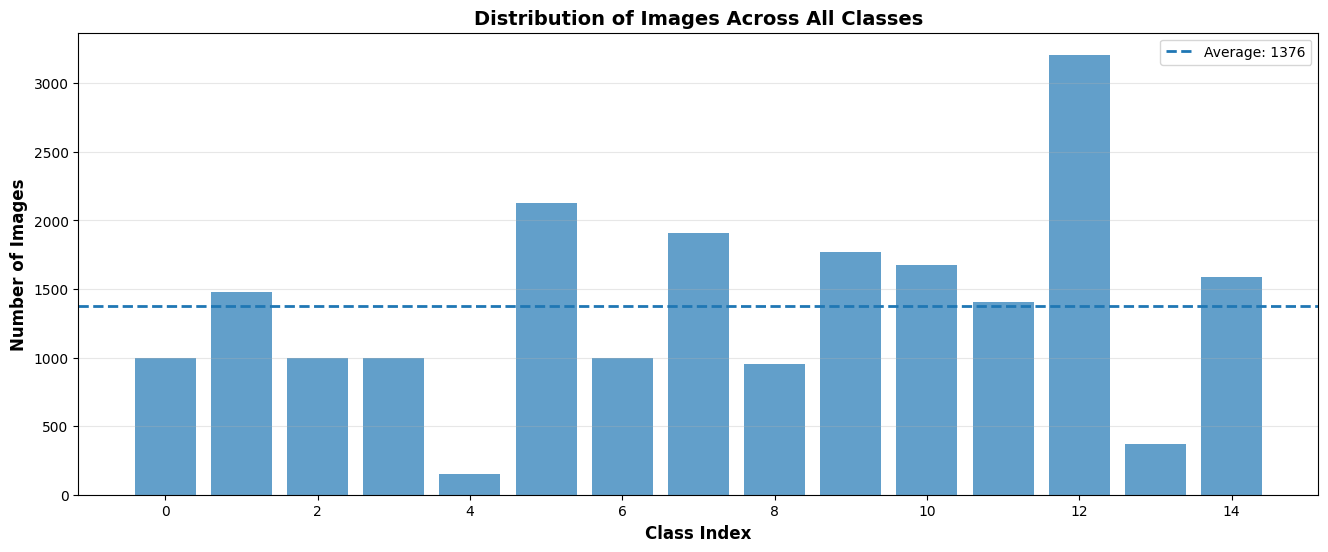

In [ ]:
# ============================================
# Visualize Class Distribution (SINGLE PLOT)
# ============================================

import matplotlib.pyplot as plt
import numpy as np

# Calculate statistics
total_images = sum(class_distribution.values())
avg_images = np.mean(list(class_distribution.values()))

# Create figure with ONE plot
fig, ax = plt.subplots(figsize=(16, 6))

class_names_short = [cls[:30] for cls in class_distribution.keys()]
counts = list(class_distribution.values())

ax.bar(range(len(counts)), counts, alpha=0.7)
ax.axhline(y=avg_images, linestyle='--', linewidth=2, label=f'Average: {avg_images:.0f}')

ax.set_xlabel('Class Index', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Images Across All Classes', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.show()


#

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize to [0,1]
    rotation_range=20,                 # ±20° rotation (increased from 10)
    width_shift_range=0.2,             # Shift horizontally by 20%
    height_shift_range=0.2,            # Shift vertically by 20%
    shear_range=0.15,                  # Shear transformation
    zoom_range=0.2,                    # Zoom in/out by 20%
    horizontal_flip=True,              # Random horizontal flip
    brightness_range=[0.8, 1.2],       # ±20% brightness variation
    fill_mode='nearest',               # How to fill empty pixels
    validation_split=0.2               # 20% for validation
)

# Validation data generator (NO augmentation, only rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

print("✓ Data augmentation configured!")
print("\nTraining augmentations:")
print("  - Rotation: ±20°")
print("  - Shifts: ±20%")
print("  - Zoom: ±20%")
print("  - Brightness: 80-120%")
print("  - Horizontal flip: Yes")
print("\nValidation: Only rescaling (no augmentation)")

✓ Data augmentation configured!

Training augmentations:
  - Rotation: ±20°
  - Shifts: ±20%
  - Zoom: ±20%
  - Brightness: 80-120%
  - Horizontal flip: Yes

Validation: Only rescaling (no augmentation)


#📌3. Splitting the Dataset into Train, Validation, and Test Sets

## Splitting the Data
3.1 Creating Clean Dataset Folders (dataset/train/ , dataset/val/ , dataset/test/)

3.2 Filtering Valid Images and Splitting by Class

3.3 Train / Validation / Test Split (60% train, 20% validation, 20% test)

3.4 Copying Images Into Their Folders

In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import os
from PIL import Image

# FIX: Correctly set the data directory
# The path from kagglehub includes the dataset root
data_dir = os.path.join(path, 'PlantVillage')

# Check if this path exists
if not os.path.exists(data_dir):
    # If not, path might already be the PlantVillage folder
    data_dir = path
    print(f"Using path directly: {data_dir}")
else:
    print(f"Using PlantVillage subdirectory: {data_dir}")

# Verify it's a directory
if not os.path.isdir(data_dir):
    print(f"ERROR: {data_dir} is not a directory!")
    print(f"Let's find the correct path...")

    # Find the actual PlantVillage directory
    import glob
    possible_paths = glob.glob('/kaggle/input/**/PlantVillage', recursive=True)
    if possible_paths:
        data_dir = possible_paths[0]
        print(f"✓ Found PlantVillage at: {data_dir}")
    else:
        print("Could not find PlantVillage directory")
        # List what's in path to debug
        print(f"\nContents of path variable ({path}):")
        if os.path.isdir(path):
            print(os.listdir(path))

# Now continue with the split
classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
classes.sort()

print(f"\n✓ Found {len(classes)} classes")
print(f"Data directory: {data_dir}")

# Remove existing dataset folder if it exists
if os.path.exists("dataset"):
    shutil.rmtree("dataset")

# Create directories
os.makedirs("dataset/train", exist_ok=True)
os.makedirs("dataset/val", exist_ok=True)
os.makedirs("dataset/test", exist_ok=True)

print(f"\nProcessing {len(classes)} classes...")
print("Split: 60% Train | 20% Validation | 20% Test\n")

total_copied_files = 0
split_summary = {'train': 0, 'val': 0, 'test': 0}

for cls in classes:
    cls_path = os.path.join(data_dir, cls)

    if not os.path.isdir(cls_path):
        continue

    imgs = os.listdir(cls_path)

    # Validate images
    valid_imgs = []
    for img_name in imgs:
        src_path = os.path.join(cls_path, img_name)
        if os.path.isfile(src_path):
            try:
                img = Image.open(src_path)
                img.convert('RGB')
                valid_imgs.append(img_name)
            except Exception as e:
                pass  # Skip corrupted silently

    if not valid_imgs:
        print(f"⚠️ No valid images for class: {cls}, skipping.")
        continue

    print(f"✓ {cls}: {len(valid_imgs)} valid images")

    # Split: 60% train, 40% temp (20% val + 20% test)
    train, temp = train_test_split(valid_imgs, test_size=0.4, random_state=42)

    # Split temp: 50% val, 50% test (each is 20% of total)
    val, test = train_test_split(temp, test_size=0.5, random_state=42)

    # Copy files to respective directories
    for folder, files in [("train", train), ("val", val), ("test", test)]:
        target_dir = os.path.join(f"dataset/{folder}", cls)
        os.makedirs(target_dir, exist_ok=True)

        for f in files:
            src_path = os.path.join(cls_path, f)
            shutil.copy(src_path, os.path.join(target_dir, f))
            total_copied_files += 1
            split_summary[folder] += 1

# Print summary
print(f"\n{'='*70}")
print(f"DATA SPLIT SUMMARY")
print(f"{'='*70}")
print(f"Total files copied: {total_copied_files:,}")
print(f"\nSplit Distribution:")
print(f"  Train:      {split_summary['train']:,} images ({split_summary['train']/total_copied_files*100:.1f}%)")
print(f"  Validation: {split_summary['val']:,} images ({split_summary['val']/total_copied_files*100:.1f}%)")
print(f"  Test:       {split_summary['test']:,} images ({split_summary['test']/total_copied_files*100:.1f}%)")
print(f"{'='*70}")

# Verify folder structure
print(f"\n✓ Dataset structure created:")
print(f"  📁 dataset/")
print(f"     ├── 📁 train/ ({len(os.listdir('dataset/train'))} classes)")
print(f"     ├── 📁 val/ ({len(os.listdir('dataset/val'))} classes)")
print(f"     └── 📁 test/ ({len(os.listdir('dataset/test'))} classes)")

Using PlantVillage subdirectory: /kaggle/input/plantdisease/PlantVillage

✓ Found 15 classes
Data directory: /kaggle/input/plantdisease/PlantVillage

Processing 15 classes...
Split: 60% Train | 20% Validation | 20% Test

✓ Pepper__bell___Bacterial_spot: 997 valid images
✓ Pepper__bell___healthy: 1478 valid images
✓ Potato___Early_blight: 1000 valid images
✓ Potato___Late_blight: 1000 valid images
✓ Potato___healthy: 152 valid images
✓ Tomato_Bacterial_spot: 2127 valid images
✓ Tomato_Early_blight: 1000 valid images
✓ Tomato_Late_blight: 1909 valid images
✓ Tomato_Leaf_Mold: 952 valid images
✓ Tomato_Septoria_leaf_spot: 1771 valid images
✓ Tomato_Spider_mites_Two_spotted_spider_mite: 1676 valid images
✓ Tomato__Target_Spot: 1404 valid images
✓ Tomato__Tomato_YellowLeaf__Curl_Virus: 3208 valid images
✓ Tomato__Tomato_mosaic_virus: 373 valid images
✓ Tomato_healthy: 1591 valid images

DATA SPLIT SUMMARY
Total files copied: 20,638

Split Distribution:
  Train:      12,377 images (60.0%)
  

#📌 Balancing Dataset with Augmentation

In [ ]:

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
import random

# Parameters
target_count = max(class_distribution.values())  # target images per class
save_augmented = True  # whether to save augmented images to disk
augmented_dir = "dataset_balanced/train"

os.makedirs(augmented_dir, exist_ok=True)

# Augmentation function (same as train_datagen)
def augment_image(img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    aug_iter = train_datagen.flow(x, batch_size=1)
    aug_img = next(aug_iter)[0].astype('uint8')
    return array_to_img(aug_img)

# Process each class
for cls in classes:
    src_dir = os.path.join("dataset/train", cls)
    dst_dir = os.path.join(augmented_dir, cls)
    os.makedirs(dst_dir, exist_ok=True)

    images = [f for f in os.listdir(src_dir) if os.path.isfile(os.path.join(src_dir, f))]
    num_images = len(images)

    # Copy original images
    for f in images:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_dir, f))

    print(f"Class {cls}: {num_images} images")

    # Augment until reaching target_count
    while num_images < target_count:
        img_name = random.choice(images)
        img_path = os.path.join(src_dir, img_name)
        img = load_img(img_path, target_size=(224,224))
        aug_img = augment_image(img)

        # Save augmented image
        if save_augmented:
            aug_name = f"aug_{num_images}_{img_name}"
            aug_img.save(os.path.join(dst_dir, aug_name))
        num_images += 1

    print(f"✓ {cls} balanced to {num_images} images")

print(" Dataset balancing complete!")


Class Pepper__bell___Bacterial_spot: 598 images
✓ Pepper__bell___Bacterial_spot balanced to 3209 images
Class Pepper__bell___healthy: 886 images
✓ Pepper__bell___healthy balanced to 3209 images
Class Potato___Early_blight: 600 images
✓ Potato___Early_blight balanced to 3209 images
Class Potato___Late_blight: 600 images
✓ Potato___Late_blight balanced to 3209 images
Class Potato___healthy: 91 images
✓ Potato___healthy balanced to 3209 images
Class Tomato_Bacterial_spot: 1276 images
✓ Tomato_Bacterial_spot balanced to 3209 images
Class Tomato_Early_blight: 600 images
✓ Tomato_Early_blight balanced to 3209 images
Class Tomato_Late_blight: 1145 images
✓ Tomato_Late_blight balanced to 3209 images
Class Tomato_Leaf_Mold: 571 images
✓ Tomato_Leaf_Mold balanced to 3209 images
Class Tomato_Septoria_leaf_spot: 1062 images
✓ Tomato_Septoria_leaf_spot balanced to 3209 images
Class Tomato_Spider_mites_Two_spotted_spider_mite: 1005 images
✓ Tomato_Spider_mites_Two_spotted_spider_mite balanced to 320

#📌 EfficientNetB3 Model

#**EfficientNetB3 model architecture, compilation, and training**

In [ ]:

# ============================================
# 📌 CELL 2: Dataset Paths (USES EXISTING STRUCTURE)
# ============================================
train_dir = "dataset_balanced/train"
val_dir = "dataset/val"
test_dir = "dataset/test"


img_height = img_width = 224 # change to 300 if GPU allows
batch_size = 32
num_classes = len(os.listdir(train_dir))


print(f"Number of classes: {num_classes}")

Number of classes: 15


In [ ]:
# ============================================
# 📌 CELL 3: Data Generators (EFFICIENTNET CORRECT)
# ============================================
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input,
rotation_range=10,
width_shift_range=0.1,
height_shift_range=0.1,
zoom_range=0.1,
horizontal_flip=True
)


val_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical'
)


val_generator = val_datagen.flow_from_directory(
val_dir,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical'
)

Found 48135 images belonging to 15 classes.
Found 4127 images belonging to 15 classes.


In [ ]:
# ============================================
# 📌 CELL 4: Build EfficientNetB3 Model
# ============================================
base_model = EfficientNetB3(
weights='imagenet',
include_top=False,
input_shape=(img_height, img_width, 3)
)


base_model.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 11,180,862 (42.65 MB)

 Trainable params: 397,327 (1.52 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
# ============================================
# 📌 CELL 5: Compile & Train (Frozen Base)
# ============================================
model.compile(
optimizer=Adam(learning_rate=3e-5),
loss='categorical_crossentropy',
metrics=['accuracy']
)


history_frozen = model.fit(
train_generator,
epochs=20,
validation_data=val_generator
)
# ============================================
# 📌 CELL 6: Fine-Tuning EfficientNetB3
# ============================================
base_model.trainable = True




for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(+



optimizer=Adam(learning_rate=1e-5),
loss='categorical_crossentropy',
metrics=['accuracy']
)


history_finetune = model.fit(
train_generator,
epochs=20,
validation_data=val_generator
)

Epoch 1/20
 531/1505 ━━━━━━━━━━━━━━━━━━━━ 1:23:39 5s/step - accuracy: 0.1656 - loss: 2.5312

In [ ]:
# ============================================
# 📌 CELL 7: Evaluate on Test Set
# ============================================
test_generator = val_datagen.flow_from_directory(
test_dir,
target_size=(img_height, img_width),
batch_size=batch_size,
class_mode='categorical',
shuffle=False
)


loss, accuracy = model.evaluate(test_generator)


print("\n==============================")
print(f"EfficientNetB3 Test Accuracy: {accuracy * 100:.2f}%")
print("==============================")

In [ ]:
# ============================================
# 📌 CELL 8: Save Model
# ============================================
model.save("efficientnetb3_corrected.keras")
print("Model saved successfully")